In [1]:
# @title Import

!pip install trdg
!pip install easyocr

# Imports
import copy
import torch
import random
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.auto import tqdm
from IPython.display import HTML, display

from trdg.generators import GeneratorFromStrings
from PIL import Image
import os
import csv
import string

import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

import easyocr

import editdistance

import re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Reason for being yanked: Doesn't work with Python 2
  Created wheel for diffimg: filename=diffimg-0.2.3-py3-none-any.whl size=4019 sha256=b846fc7ba338c74ef143923272032f7729ce2117ddf5f012551fb01508e11a1f
  Stored in directory: /root/.cache/pip/wheels/90/57/92/d4259a51f20cf92a473b567a009674e3390852b7fab19be6dc
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=d5034fa6c9bf79a075ce088d1ab98f37d9903935363f6cd981eadf3cec682bf5
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built diffimg wikipedia
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 38.4 

In [2]:
# @title Set random seed
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [6]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [ ]:
# @title Generate the dataset (Run once or import it)

output_dir = "ocr_dataset"
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(output_dir, "labels.csv")

# Define the path to the Stencil font file
stencil_font_path = "stencils.tff"
# Check if the font file exists at the specified path
import os
if not os.path.isfile(stencil_font_path):
    raise FileNotFoundError(f"Font file not found: {stencil_font_path}")

def generate_random_word(length=10):
    letters = string.ascii_lowercase + ' '
    return ''.join(random.choice(letters) for i in range(length))

# Function to save images with labels
def save_handwritten_text_images(output_dir, csv_file, num_samples=1000):
    # Generate random words
    random_words = [generate_random_word(10) for _ in range(num_samples)]

    # Create generator for handwritten text
    generator = GeneratorFromStrings(
        random_words,
        blur=0,  # No blur
        random_blur=False,
        distorsion_type=0,  # No distortion
        size=32,  # Font size
        language="en",  # Language set to English
        fonts=[stencil_font_path]
    )

    labels = []
    fixed_width = 256
    fixed_height = 56

    for count, (img, lbl) in enumerate(tqdm(generator, total=num_samples, desc="Creating Datas")):
        if count >= num_samples:
          break
        img = img.convert("L")  # Convert image to grayscale
        # Resize the image to fixed dimensions
        img = img.resize((fixed_width, fixed_height), Image.ANTIALIAS)
        # Save image with related filename
        img_filename = os.path.join(output_dir, f"{count+1}.png")
        img.save(img_filename)
        # print(f"Saved {img_filename} with label {lbl}")
        labels.append((f"{count+1}.png", lbl))

    # Save labels to CSV
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow( ["image_name", "label"])
        for img_name, label in labels:
            writer.writerow([img_name, label])

# Generate and save images
num_samples = 10000 ## USER 20 000
save_handwritten_text_images(output_dir, csv_file, num_samples=num_samples)

FileNotFoundError: Font file not found: stencils.tff

In [4]:
#  @title Extract the dataset with a zip file

from google.colab import drive
drive.mount('/content/drive')

# %cd /content
# !zip -r ocr_dataset.zip ocr_dataset
# from google.colab import files
# files.download('ocr_dataset.zip')

Mounted at /content/drive


**corruption**

In [27]:
# Corruption functions
def add_salt_and_pepper_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(1000, 5000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 255
    number_of_pixels = random.randint(400, 10000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 0
    return image

def add_pepper_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(5000, 20000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 0
    return image

def add_salt_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(1000, 5000) #(300, 50000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 255 #255
    return image

def color_shift(image):
    img = np.array(image)
    h, w = img.shape
    rand_shift = random.uniform(-50, 50)
    shifted = img + rand_shift
    shifted = np.clip(shifted, 0, 255)
    shifted_image = Image.fromarray(shifted.astype(np.uint8))
    return shifted_image

def adjust_contrast(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    Y = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)[:, :, 0]
    min_val = np.min(Y)
    max_val = np.max(Y)
    brightness = (max_val + min_val) / 2
    contrast = (max_val - min_val) / (max_val + min_val)
    brightness = brightness
    contrast = random.uniform(0.01, 10.0)
    image2 = cv2.convertScaleAbs(image_rgb, alpha=contrast, beta=brightness)
    return image2

def apply_corruption(image_tensor, corruption_type):
    # Convert image tensor to NumPy array and transpose to (H, W, C)
    image = image_tensor.numpy().transpose(1, 2, 0)

    if corruption_type == 'salt_and_pepper':
        corrupted_image = add_salt_and_pepper_noise(image)
    elif corruption_type == 'pepper':
        corrupted_image = add_pepper_noise(image)
    elif corruption_type == 'salt':
        corrupted_image = add_salt_noise(image)
    elif corruption_type == 'color_shift':
        corrupted_image = color_shift(image)
    elif corruption_type == 'adjust_contrast':
        # Convert to PIL image for adjust_contrast function
        pil_image = Image.fromarray(image.astype(np.uint8))
        corrupted_image = adjust_contrast(pil_image)
        corrupted_image = np.array(corrupted_image)
    else:
        corrupted_image = image  # If no corruption type specified, return original image

    # Convert back to PyTorch tensor and transpose to (C, H, W)
    corrupted_image_tensor = torch.from_numpy(corrupted_image.transpose(2, 0, 1)).float()

    return corrupted_image_tensor

In [33]:
def get_data_loader(tsf=-1, p=0.1 , cor=-2):
  # -1 : nothing
  # 0 : rotation
  # 1 : affine tsf
  # 2 Gaussian blur
  # ...
  # @title Data Loader
  class CustomImageDataset(Dataset):
      def __init__(self, csv_file, img_dir, transform=None , curroption=None):
          self.img_labels = pd.read_csv(csv_file)
          self.img_dir = img_dir
          self.transform = transform

      def __len__(self):
          return len(self.img_labels)

      def __getitem__(self, idx):
          img_name = self.img_labels.iloc[idx, 0]
          img_path = os.path.join(self.img_dir, img_name)
          image = Image.open(img_path)
          label = self.img_labels.iloc[idx, 1]

          if self.transform:
              image = self.transform(image)

          return image, label

  # apply corruptions to the preprocess

  float_to_odd_number = lambda float_value: (lambda n: n if n % 2 != 0 else n + 1 if n < float_value else n - 1)(int(round(float_value)))

  corr_list = [transforms.RandomRotation(degrees=p*20), transforms.RandomAffine(degrees=p*20), transforms.GaussianBlur(float_to_odd_number(p*20))]

  # compose transformations including the specified corruption
  if tsf == -1:
    transform = transforms.Compose([
                                  transforms.ToTensor()
                                  ])
  else:
    transform = transforms.Compose([
                                  corr_list[tsf],
                                  transforms.ToTensor()
                                  ])
  if cor == -2:
    corruption='None'
  else:
    corruption='salt_and_pepper'


  # Create an instance of the custom dataset
  csv_file = "/content/drive/MyDrive/labels_legacy.csv" # Using pathlib to be compatible with all OS's
  img_dir = "/content/drive/MyDrive/OCR_Dataset "

  dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

  # Split dataset into training, validation, and test sets
  dataset_size = len(dataset)
  train_size = int(0.20 * dataset_size)
  val_size = int(0.70 * dataset_size)
  test_size = int(0.10 * dataset_size) # reduced otherwise too slow

  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

  # Create DataLoaders for each dataset
  batch_size = 32  # Adjust batch size as needed
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [9]:
# @title Initialize easyocr (Only once)
# This needs to run only once to load the model into memory
reader = easyocr.Reader(['en'])


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [34]:
# @title Helper function

# Function to calculate Character Error Rate (CER)
# CER is calculated as the number of character-level errors (insertions, deletions, substitutions)
# divided by the total number of characters in the ground truth text.
def calculate_cer(gt, pred):
    return editdistance.eval(gt, pred) / len(gt)

# Function to calculate Word Error Rate (WER)
def calculate_wer(gt, pred):
    gt_words = gt.split()
    pred_words = pred.split()
    return editdistance.eval(gt_words, pred_words) / len(gt_words)

# Function to evaluate the EasyOCR model and display images with results
def evaluate_easyocr(reader, dataloader):
    total_chars = 0
    total_words = 0
    total_char_errors = 0
    total_word_errors = 0
    correct = 0
    total = 0

    image_count = 0
    max_images_to_display = 10

    for images, labels in tqdm(dataloader, desc="Evaluating"):
        for img, label in zip(images, labels):
            # Ensure the image is in the correct format for EasyOCR
            if isinstance(img, Image.Image):
                img = np.array(img)
            elif isinstance(img, torch.Tensor):
                img = img.numpy().transpose(1, 2, 0) * 255  # Convert tensor to numpy array and scale
                img = img.astype('uint8')

            result = reader.readtext(img)[0]  # Set detail=0 to get only the recognized text
            prediction = result[1].lower()

            # # Calculate accuracy
            # # Replace single spaces with no space
            # prediction = re.sub(r'(?<! ) (?! )', '', prediction)
            # # Replace double spaces with single space
            # prediction = re.sub(r' {2}', ' ', prediction)
            # print(f'Prediction: {prediction.lower()}')
            # print(f'Label: {label.lower()}')
            if prediction == label:
                correct += 1
            total += 1
            # print(f'Correct: {correct}, Total: {total}')

            # Calculate CER
            cer = calculate_cer(label, prediction)
            total_char_errors += cer #* len(label)
            if len(label) != 10 :
              print("err")
            # total_chars += len(label)

            # Calculate WER
            wer = calculate_wer(label, prediction)
            total_word_errors += wer * len(label.split())
            total_words += len(label.split())

            # Display the image with OCR results for the first 10 images
            if image_count < max_images_to_display:
                display_image_with_results(result, img)
                image_count += 1

    accuracy = correct / total
    cer = total_char_errors / total
    wer = total_word_errors / total_words
    return accuracy, cer, wer

# Function to display image with EasyOCR results
def display_image_with_results(res, img):
    # show the image and plot the results
    plt.imshow(img)
    # bbox coordinates of the detected text
    xy = res[0]
    xy1, xy2, xy3, xy4 = xy[0], xy[1], xy[2], xy[3]
    # text results and confidence of detection
    det, conf = res[1], res[2]
    # show time :)
    plt.plot([xy1[0], xy2[0], xy3[0], xy4[0], xy1[0]], [xy1[1], xy2[1], xy3[1], xy4[1], xy1[1]], 'r-')
    plt.text(xy1[0], xy1[1], f'{det} [{round(conf, 2)}]', c='r')
    plt.show()

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

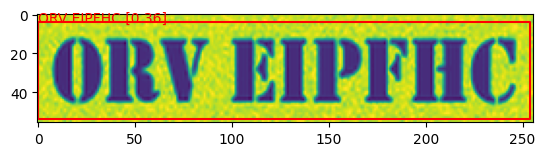

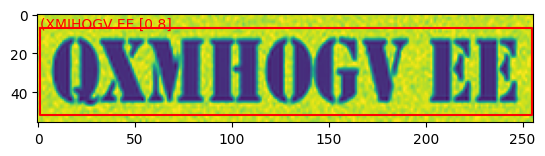

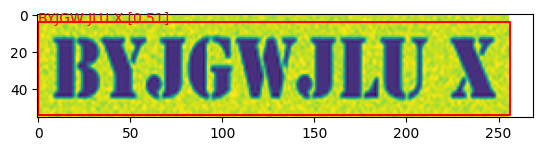

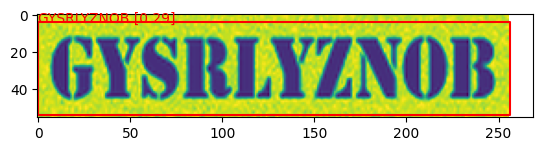

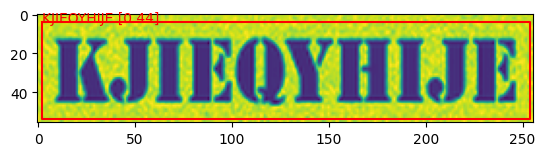

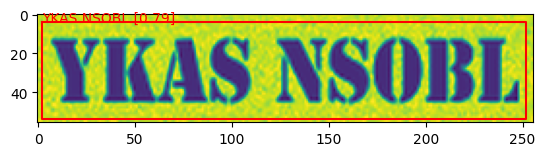

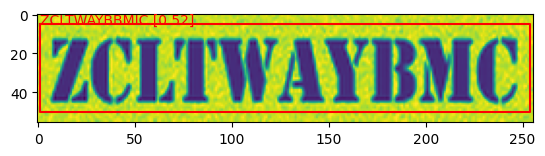

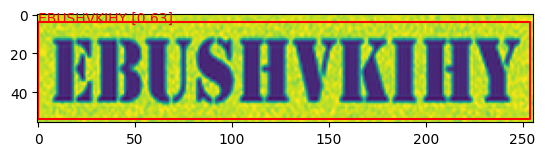

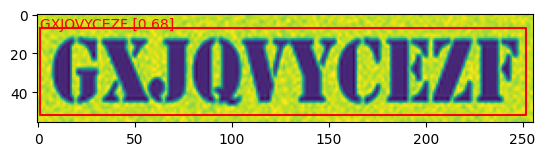

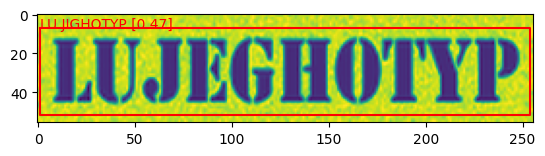

Test Accuracy: 0.1590
Test CER: 0.2329
Test WER: 0.7391


In [35]:
# @title Evaluation of a given model

# Evaluate the model easyocr
train_loader, val_loader, test_loader = get_data_loader(tsf=-1, p=0.1 , cor=-3)   # -1 : nothing, 0 : rotation, 1 : affine tsf, 2 Gaussian blur
test_accuracy, test_cer, test_wer = evaluate_easyocr(reader, test_loader) # test over 1000 images
print(f'Test Accuracy: {test_accuracy:.4f}') # we want it to be at 100% ideally
print(f'Test CER: {test_cer:.4f}') # we want it to be at 0% ideally
print(f'Test WER: {test_wer:.4f}') # we want it to be at 0% ideally